# *K-means* e *bisecting K-means* 

O objetivo deste projeto é realizar uma análise qualitative entre o K-means e o bisecting K-means. As bases de dados utilizadas serão a [Iris Dataset](https://archive.ics.uci.edu/ml/datasets/iris) e o [Wine Dataset](http://archive.ics.uci.edu/ml/datasets/Wine).

O pré-processamento e o estudo da redução de dimensionalidade fazem parte da análise e também terão protagonismo no teste. 


In [73]:
from sklearn import metrics
from time    import time
from math    import sqrt
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import random            as rd

# Argumentos e pré-definições do seaborn
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set(style="ticks")

filepath_iris = '../data/iris.csv'
filepath_wine = '../data/wine.csv'

## Carregando os dados e entendendo o que eles significam

A primeira parte deste teste é importar as bases de dados e entender o que elas já dizem logo de cara.

### Entendendo o *dataset* Iris
Este dataset apresenta 3 espécies de uma planta florífera do gênero iris, a setosa, versicolor e virginica. Para cada uma das classes existem 50 exemplares e 4 características, ou *features*, que são os comprimentos e larguras tanto da pétala quanto da sépala das flores.

Os dados são importados para um *DataFrame* do *pandas* e descrevemos suas principais características para iniciar a análise. Primeiramente conferimos que a contagem para cada uma das *features* é 150 e também a média para todos os valores, além de outras informações. Este tipo de retorno é interessante para começar a entender como cada característica influencia na identificação da espécie. Mas, levando em conta que nosso objetivo é espécie das flores, seria mais interessante agrupar estes dados, então, justamente pela especie. E é o que faremos em seguida.

In [71]:
iris_df = pd.read_csv(filepath_iris)
iris_data.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [74]:
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [72]:
iris_data.groupby('species').agg(['mean', 'median'])

sepal_length        sepal_width        petal_length         \
                        mean median        mean median         mean median   
species                                                                      
Iris-setosa            5.006    5.0       3.418    3.4        1.464   1.50   
Iris-versicolor        5.936    5.9       2.770    2.8        4.260   4.35   
Iris-virginica         6.588    6.5       2.974    3.0        5.552   5.55   

                petal_width         
                       mean median  
species                             
Iris-setosa           0.244    0.2  
Iris-versicolor       1.326    1.3  
Iris-virginica        2.026    2.0

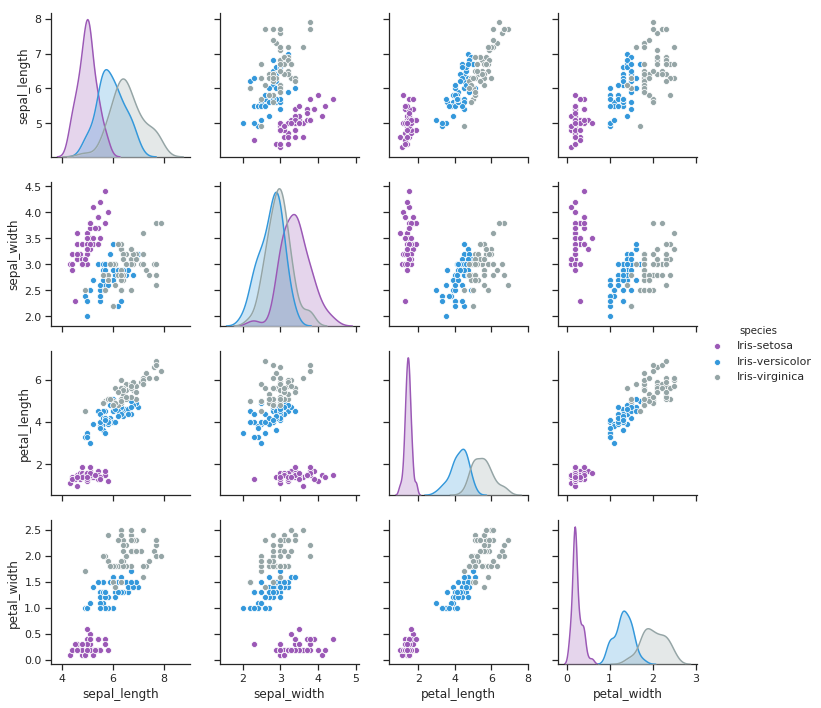

In [68]:
sns.pairplot(iris_data, hue="species", palette=sns.color_palette(flatui))

wojqowjroqiwr

> aqui ushiufhsdiufh\
> siohfsiodhfhsd\
> sdihfisudhfiushd\

uhfiuwefhewiu

In [22]:
def plotter(doc, ks, label):
    X,Y = zip(*doc)
    kx,ky = zip(*ks)

    plt.scatter(x=X,y=Y, marker='o', c=label)
    plt.scatter(x=kx, y=ky, marker='x', color='black', s=150)
    
def plotter2(doc):
    X,Y = zip(*doc)
    plt.scatter(x=X,y=Y, marker='o')

In [23]:
def euclidianDistance(p1, p2):
    return math.sqrt( (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 )

In [24]:
MAX_ITER = 15
def goCondition(old_centroids, curr_centroids, itter):
    if itter >= MAX_ITER: return False    
    
    ctd = 0
    for old_centroid,curr_centroid in zip(old_centroids,curr_centroids):
        if abs(old_centroid[0]-curr_centroid[0]) <= 0.001 and\
           abs(old_centroid[1]-curr_centroid[1]) <= 0.001:
               ctd += 1
    if ctd == len(curr_centroids): return False
    
    return True

In [25]:
def definePatternship(S, centroids, dist_func):
    color = {cen:i for i,cen in enumerate(centroids)}
    labels = []
    
    for p in S:
        distances = [(dist_func(p, centroid),centroid) for centroid in centroids]
        
        closest_centroid = min(distances, key=lambda x: x[0])[1]
        
        labels.append(color[closest_centroid])
    
    return labels

In [26]:
def defineNewCentroids(S, labels):
    centroids = dict()
    for p,label in zip(S,labels):
        if label not in centroids:
            centroids[label] = {"x":p[0], "y":p[1], "len":1}
        else:
            centroids[label]["x"] += p[0]
            centroids[label]["y"] += p[1]
            centroids[label]["len"] += 1
 
        
    return [(c['x']/c['len'], c['y']/c['len']) for c in centroids.values()]

In [27]:

def kmeans(S, k, dist_func):
    curr_centroids = [tuple(s) for s in rd.sample(S, k)]
    old_centroids  = [tuple(s) for s in rd.sample(S, k)]
    itter = 0
    
    while goCondition(old_centroids, curr_centroids, itter):
        old_centroids = curr_centroids       
        predicted = definePatternship(S, old_centroids, dist_func)
        curr_centroids = defineNewCentroids(S, predicted)
        itter += 1
        
    return predicted,old_centroids

Melhor valor para o K:   3
Obtendo uma acurácia de: 0.8641855068202222 (v_measure_score) 
Tempo: 0.41509032249450684


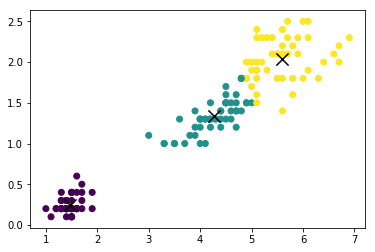

In [28]:
document = [[pl, pw] for pl,pw in zip(list(iris_data.petal_length), list(iris_data.petal_width))]

best_accuracy = -1
best_centr = None
y_pred = []
best_label = []
best_k = 0

inicio = time()
# for _ in range(30):
for K in range(1, 30):
    y_pred, centroids = kmeans(document, K, euclidianDistance)

#     accuracy = metrics.adjusted_rand_score(y_true, y_pred)
    try:
        accuracy = metrics.v_measure_score(y_true, y_pred)
    except:
        print(y_pred)


    if accuracy >= best_accuracy:
        best_accuracy = accuracy
        best_centr = centroids
        best_k = K
        best_label = y_pred
            
final = time()
    
print(f"Melhor valor para o K:   {best_k}\nObtendo uma acurácia de: {best_accuracy} (v_measure_score) \nTempo: {final-inicio}")
plotter(document, best_centr, best_label)

Time: 0.21809864044189453

Gráfico: K por Acurácia


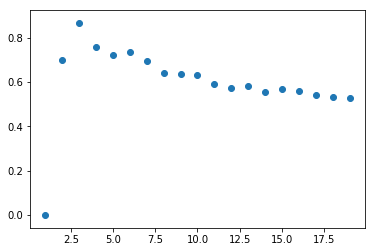

In [29]:
doc = [[pl, pw] for pl,pw in zip(list(iris_data.petal_length), list(iris_data.petal_width))]
document = []

inicio = time()
for K in range(1, 20):
    y_pred, _ = kmeans(doc, K, euclidianDistance)

#     accuracy = metrics.adjusted_rand_score(y_true, y_pred)
    try:
        accuracy = metrics.v_measure_score(y_true, y_pred)
    except:
        print(y_pred)

    document.append((K, accuracy))

final = time()

plotter2(document)

print(f"Time: {final-inicio}\n\nGráfico: K por Acurácia")